In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
print("Loading and preprocessing data...")

# Get the absolute path to the project root directory
project_root = Path.cwd().parent 
DATA_DIR = project_root / "data"

df = pd.read_csv(DATA_DIR / "train.csv")
df["image_path"] = df["id_code"].apply(lambda x: str(DATA_DIR / "train_images" / f"{x}.png"))

Loading and preprocessing data...


In [5]:
X = []
y = []

for idx, row in df.iterrows():
    image_path = row['image_path']
    
    img = cv2.imread(image_path)
    
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    X.append(img)
    y.append(row['diagnosis'])
    

X = np.array(X)
y = np.array(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Data splits loaded.")

Data splits loaded.


In [12]:
# --- 2. Define and Train the Custom CNN Model ---
print("\n--- Training Custom CNN Model ---")
custom_cnn = Sequential()
custom_cnn.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='tanh', input_shape=(224,224,3)))
custom_cnn.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
custom_cnn.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='tanh'))
custom_cnn.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
custom_cnn.add(Flatten())
custom_cnn.add(Dense(120, activation='relu'))
custom_cnn.add(Dense(84, activation='relu'))
custom_cnn.add(Dense(5, activation='softmax'))

custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)


--- Training Custom CNN Model ---


c:\Users\divya\anaconda3\envs\aptos-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 510ms/step - accuracy: 0.6541 - loss: 1.3437 - val_accuracy: 0.6667 - val_loss: 0.9098
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 505ms/step - accuracy: 0.7238 - loss: 0.7731 - val_accuracy: 0.7077 - val_loss: 0.8550
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 503ms/step - accuracy: 0.7255 - loss: 0.7499 - val_accuracy: 0.6885 - val_loss: 0.8855
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 505ms/step - accuracy: 0.7474 - loss: 0.7071 - val_accuracy: 0.6940 - val_loss: 0.8898
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 507ms/step - accuracy: 0.7334 - loss: 0.7249 - val_accuracy: 0.6967 - val_loss: 0.9036
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 520ms/step - accuracy: 0.7402 - loss: 0.7087 - val_accuracy: 0.7077 - val_loss: 0.8848
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 528ms/step - accuracy: 0.7497 - loss: 0.6772 - val_accuracy: 0.7131 - val_loss: 0.7956
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 545ms/step - accuracy: 0.7607 - loss: 0.6476 - val_accu

In [10]:
# --- 3. Define and Train the VGG16 Model ---
print("\n--- Training VGG16 Transfer Learning Model ---")
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model_vgg.layers:
    layer.trainable = False

vgg16_model = Sequential([
    base_model_vgg,
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(5, activation='softmax')
])
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg16_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)




--- Training VGG16 Transfer Learning Model ---
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 434s 5s/step - accuracy: 0.6845 - loss: 0.9597 - val_accuracy: 0.7131 - val_loss: 0.8793
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 363s 4s/step - accuracy: 0.7426 - loss: 0.7321 - val_accuracy: 0.6940 - val_loss: 0.8680
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 0.7532 - loss: 0.6715 - val_accuracy: 0.7077 - val_loss: 0.8933
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 0.7637 - loss: 0.6344 - val_accuracy: 0.7322 - val_loss: 0.7693
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 0.7750 - loss: 0.6114 - val_accuracy: 0.7213 - val_loss: 0.7983
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 612s 7s/step - accuracy: 0.7777 - loss: 0.6112 - val_accuracy: 0.7186 - val_loss: 0.7530
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 592s 6s/step - accuracy: 0.7917 - loss: 0.5462 - val_accuracy: 0.7049 - val_loss: 0.8457
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 540s 6s/step - accuracy: 

In [ ]:
# --- 4. Define and Train the ResNet50V2 Model ---
print("\n--- Training ResNet50V2 Transfer Learning Model ---")

base_model_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_resnet.layers:
    layer.trainable = False

resnet_model = Sequential([
    base_model_resnet,
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(5, activation='softmax')
])
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)


--- Training ResNet50V2 Transfer Learning Model ---
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6613 - loss: 3.4144 - val_accuracy: 0.7077 - val_loss: 1.0619
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8201 - loss: 0.5374 - val_accuracy: 0.6803 - val_loss: 1.0299
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8955 - loss: 0.3019 - val_accuracy: 0.7240 - val_loss: 1.1024
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9409 - loss: 0.1888 - val_accuracy: 0.7158 - val_loss: 1.0940
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9607 - loss: 0.1409 - val_accuracy: 0.7268 - val_loss: 1.1459
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9795 - loss: 0.0899 - val_accuracy: 0.7240 - val_loss: 1.3367
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9734 - loss: 0.1046 - val_accuracy: 0.7268 - val_loss: 1.4506
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accur


--- Evaluating Models on the Test Set ---

Evaluating Custom CNN...
Accuracy: 0.7166, Loss: 1.1548
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       181
           1       0.67      0.11      0.19        37
           2       0.69      0.69      0.69       100
           3       0.20      0.53      0.29        19
           4       0.30      0.33      0.32        30

    accuracy                           0.72       367
   macro avg       0.56      0.52      0.49       367
weighted avg       0.76      0.72      0.71       367



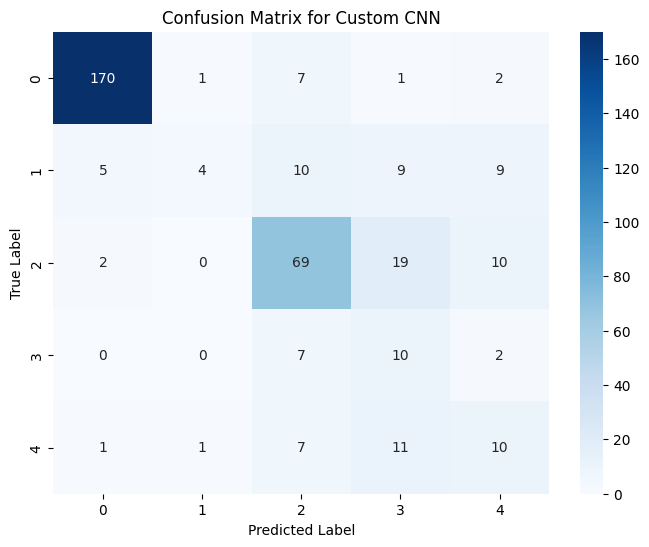


Evaluating VGG16...
Accuracy: 0.7984, Loss: 0.6332
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       181
           1       0.47      0.57      0.51        37
           2       0.78      0.78      0.78       100
           3       0.38      0.16      0.22        19
           4       0.48      0.47      0.47        30

    accuracy                           0.80       367
   macro avg       0.61      0.59      0.59       367
weighted avg       0.79      0.80      0.79       367



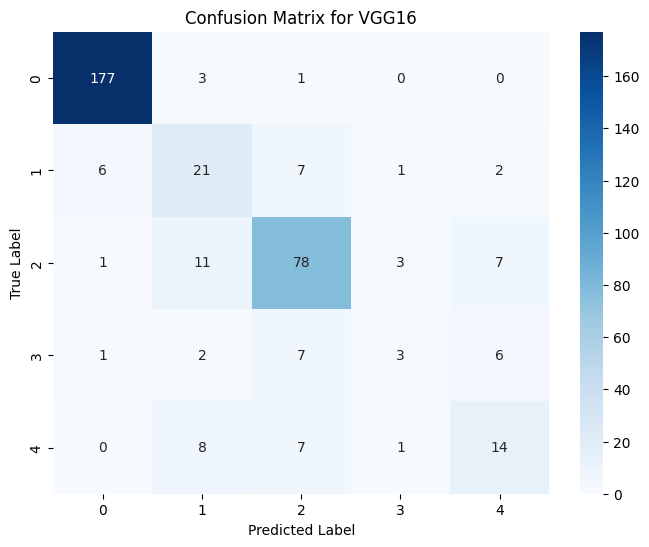


Evaluating ResNet50V2...
Accuracy: 0.7602, Loss: 1.5610
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       181
           1       0.46      0.32      0.38        37
           2       0.62      0.84      0.71       100
           3       0.30      0.16      0.21        19
           4       0.58      0.23      0.33        30

    accuracy                           0.76       367
   macro avg       0.58      0.50      0.52       367
weighted avg       0.74      0.76      0.74       367



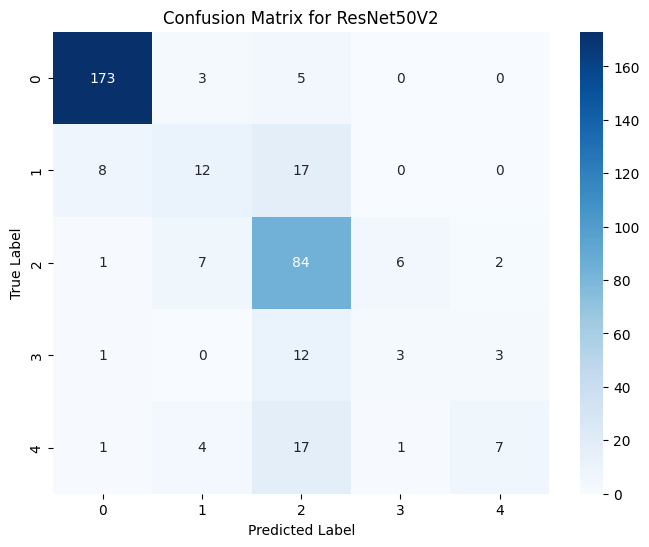

In [13]:
# --- 5. Evaluate and Compare All Models on the Test Set ---
print("\n--- Evaluating Models on the Test Set ---")

models = {
    "Custom CNN": custom_cnn,
    "VGG16": vgg16_model,
    "ResNet50V2": resnet_model
}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
    
    # Generate predictions and a classification report
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:

save_dir = '../saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the VGG16 model with the correct relative path
vgg16_model.save(os.path.join(save_dir, 'final_model_for_deployment.keras'))
print("VGG16 model saved successfully as 'saved_models/final_model_for_deployment.keras'")

VGG16 model saved successfully as 'saved_models/final_model_for_deployment.keras'
